In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:

file_path = "/content/drive/MyDrive/german_credit_data_with_risk.csv"


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score


In [10]:
df = pd.read_csv(file_path)
df.head()


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,2,49,male,1,own,little,NaN,2096,12,education,1
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,4,53,male,2,free,little,little,4870,24,car,0


In [11]:
# Afficher un aperçu du dataset
df.head()

# Obtenir des infos générales
df.info()

# Statistiques descriptives pour les colonnes numériques
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 86.1+ KB


,Unnamed: 0,Age,Job,Credit amount,Duration,Risk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,1.904000,3271.258000,20.903000,0.457000
std,288.819436,11.375469,0.653614,2822.736876,12.058814,0.498397
min,0.000000,19.000000,0.000000,250.000000,4.000000,0.000000
25%,249.750000,27.000000,2.000000,1365.500000,12.000000,0.000000
50%,499.500000,33.000000,2.000000,2319.500000,18.000000,0.000000
75%,749.250000,42.000000,2.000000,3972.250000,24.000000,1.000000
max,999.000000,75.000000,3.000000,18424.000000,72.000000,1.000000


In [12]:
df.isnull().sum()
df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

In [14]:
#Utilisation de fillna avec dictionnaire
modes = {
    'Saving accounts': df['Saving accounts'].mode()[0],
    'Checking account': df['Checking account'].mode()[0]
}
df = df.fillna(modes)


# Affichage des résultats
print("Aperçu du dataset après traitement:")
print(df.head().to_string())
print(df.head())

Aperçu du dataset après traitement:
   ID  Age     Sex  Job Housing Saving accounts Checking account  Credit amount  Duration              Purpose  Risk
0   0   67    male    2     own          little           little           1169         6             radio/TV     1
1   1   22  female    2     own          little         moderate           5951        48             radio/TV     0
2   2   49    male    1     own          little           little           2096        12            education     1
3   3   45    male    2    free          little           little           7882        42  furniture/equipment     0
4   4   53    male    2    free          little           little           4870        24                  car     0
   ID  Age     Sex  Job Housing Saving accounts Checking account  \
0   0   67    male    2     own          little           little   
1   1   22  female    2     own          little         moderate   
2   2   49    male    1     own          little           

/tmp/ipython-input-1690588271.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Credit amount', data=df_credit_combined,
/tmp/ipython-input-1690588271.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Duration', data=df_duration_combined,


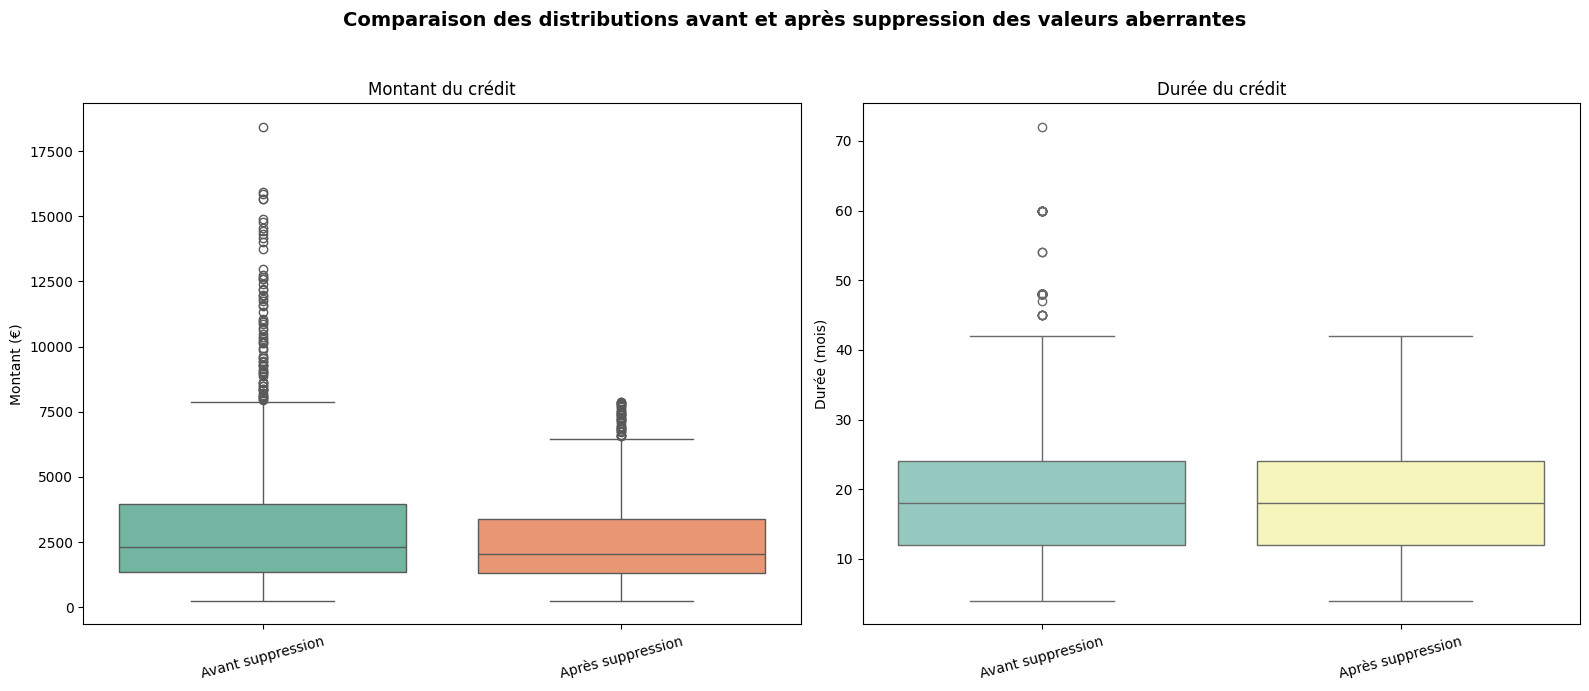

In [15]:
# Stocker le DataFrame original
df_original = df.copy()

# Suppression des outliers avec l'IQR
for col in ['Credit amount', 'Duration']:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    df = df[(df[col] >= q1 - 1.5 * iqr) & (df[col] <= q3 + 1.5 * iqr)]

# Création des DataFrames combinés pour le tracé
def prepare_combined_df(col):
    before = df_original[[col]].copy()
    before['Type'] = 'Avant suppression'
    after = df[[col]].copy()
    after['Type'] = 'Après suppression'
    return pd.concat([before, after])

df_credit_combined = prepare_combined_df('Credit amount')
df_duration_combined = prepare_combined_df('Duration')

# Création de la figure
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=False)

# Boxplot pour le montant du crédit
sns.boxplot(x='Type', y='Credit amount', data=df_credit_combined,
            palette='Set2', ax=axes[0])
axes[0].set_title('Montant du crédit')
axes[0].set_xlabel('')
axes[0].set_ylabel('Montant (€)')
axes[0].tick_params(axis='x', rotation=15)

# Boxplot pour la durée
sns.boxplot(x='Type', y='Duration', data=df_duration_combined,
            palette='Set3', ax=axes[1])
axes[1].set_title('Durée du crédit')
axes[1].set_xlabel('')
axes[1].set_ylabel('Durée (mois)')
axes[1].tick_params(axis='x', rotation=15)

# Titre général
plt.suptitle('Comparaison des distributions avant et après suppression des valeurs aberrantes', fontsize=14, weight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [16]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [17]:
df_encoded.head()

,ID,Age,Job,Credit amount,Duration,Risk,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,...,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,0,67,2,1169,6,1,True,True,False,False,...,False,False,False,False,False,False,False,True,False,False
2,2,49,1,2096,12,1,True,True,False,False,...,False,False,False,False,False,True,False,False,False,False
3,3,45,2,7882,42,0,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,4,53,2,4870,24,0,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
6,6,53,2,2835,24,0,True,True,False,False,...,False,False,False,False,False,False,True,False,False,False


In [18]:
# Create dataframes for plotting Credit amount before and after outlier removal
df_credit_before = df_original[['Credit amount']].copy()
df_credit_before['Type'] = 'Avant suppression des outliers'

df_credit_after = df[['Credit amount']].copy()
df_credit_after['Type'] = 'Après suppression des outliers'

# Combine the dataframes
df_credit_combined = pd.concat([df_credit_before, df_credit_after])

# Create dataframes for plotting Duration before and after outlier removal
df_duration_before = df_original[['Duration']].copy()
df_duration_before['Type'] = 'Avant suppression des outliers'

df_duration_after = df[['Duration']].copy()
df_duration_after['Type'] = 'Après suppression des outliers'

# Combine the dataframes
df_duration_combined = pd.concat([df_duration_before, df_duration_after])


In [20]:
# Séparer les features et la cible
X = df_encoded.drop('Risk', axis=1)
y = df_encoded['Risk']

# Normaliser les variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
# Split des données

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [22]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [23]:
# Évaluation
y_pred = model.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nMatrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred))

Accuracy : 0.9491525423728814

Matrice de confusion :
 [[78  3]
 [ 6 90]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.93      0.96      0.95        81
           1       0.97      0.94      0.95        96

    accuracy                           0.95       177
   macro avg       0.95      0.95      0.95       177
weighted avg       0.95      0.95      0.95       177



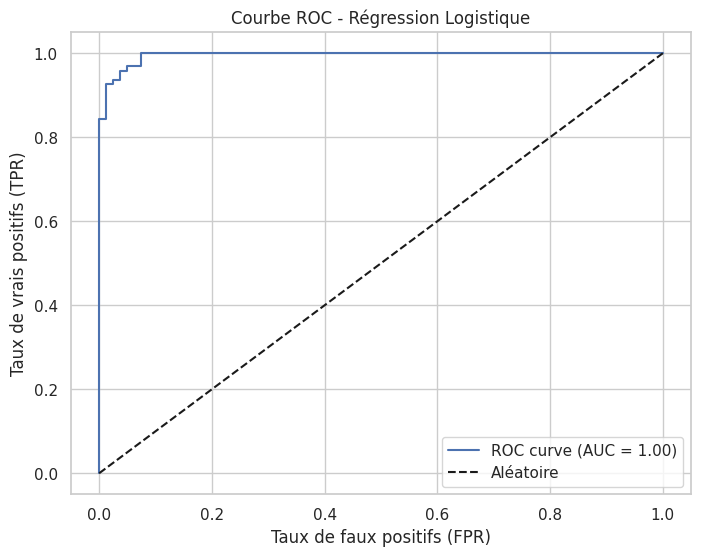

In [24]:
# Prédire les probabilités pour la classe positive (ici, '1' ou 'bon payeur')
y_probs = model.predict_proba(X_test)[:, 1]

# Calculer les faux positifs (fpr), vrais positifs (tpr) et seuils
fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label=1)

# Calculer l’AUC (aire sous la courbe ROC)
auc_score = roc_auc_score(y_test, y_probs)

# Tracer la courbe ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
plt.plot([0,1], [0,1], 'k--', label="Aléatoire")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC - Régression Logistique")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [25]:
# SPLIT D'ABORD
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Normalisation SANS data leakage
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Apprend SEULEMENT sur le train
X_test = scaler.transform(X_test)       # Applique la même transformation au test

# Modèle SIMPLE avec régularisation
model = LogisticRegression(C=0.01, max_iter=1000).fit(X_train, y_train)

# Évaluation
print("Test:", classification_report(y_test, model.predict(X_test)))

Test:               precision    recall  f1-score   support

           0       0.95      0.89      0.92       123
           1       0.91      0.96      0.93       143

    accuracy                           0.92       266
   macro avg       0.93      0.92      0.92       266
weighted avg       0.93      0.92      0.92       266



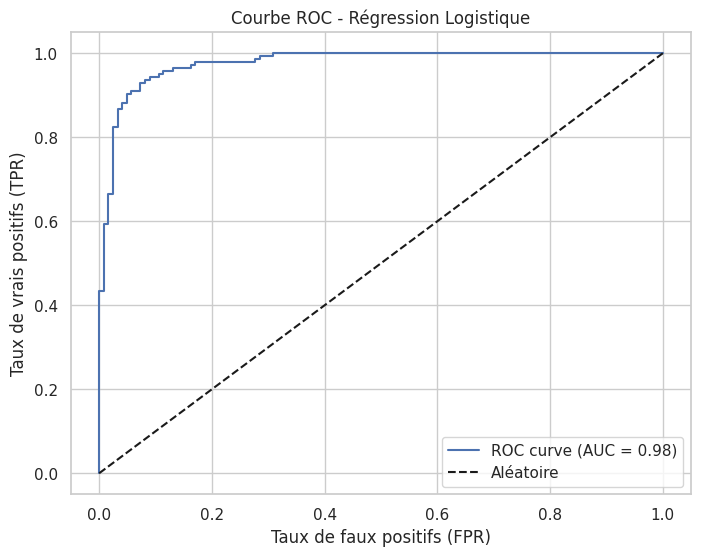

In [26]:
# Prédire les probabilités pour la classe positive (ici, '1' ou 'bon payeur')
y_probs = model.predict_proba(X_test)[:, 1]

# Calculer les faux positifs (fpr), vrais positifs (tpr) et seuils
fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label=1)

# Calculer l’AUC (aire sous la courbe ROC)
auc_score = roc_auc_score(y_test, y_probs)

# Tracer la courbe ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
plt.plot([0,1], [0,1], 'k--', label="Aléatoire")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC - Régression Logistique")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [27]:
# Évaluation
y_pred = model.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nMatrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred))

Accuracy : 0.924812030075188

Matrice de confusion :
 [[109  14]
 [  6 137]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.95      0.89      0.92       123
           1       0.91      0.96      0.93       143

    accuracy                           0.92       266
   macro avg       0.93      0.92      0.92       266
weighted avg       0.93      0.92      0.92       266

